# TriMesh vs PixMesh

Compares the quality of derivatives using `PixMesh` and `TriMesh` subclasses.

These objects use PETSc matrices to evaluate spatial derivatives.

In [1]:
import badlands
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

In [2]:
minX, maxX, resX = -5., 5., 350
minY, maxY, resY = -5., 5., 350

Xcoords = np.linspace(minX, maxX, resX)
Ycoords = np.linspace(minY, maxY, resY)

points_x, points_y = np.meshgrid(Xcoords, Ycoords)

# boundary mask
bmask = np.zeros_like(points_x, dtype=bool)
bmask[1:-1,1:-1] = True

In [3]:
# TriMesh
tri_mesh = badlands.FlatMesh("TriMesh")
tri_mesh.verbose = True
tri_mesh.build_mesh(points_x.flatten(), points_y.flatten(), bmask.flatten())

# PixMesh
pix_mesh = badlands.FlatMesh("PixMesh")
pix_mesh.verbose = True
pix_mesh.build_mesh(points_x.flatten(), points_y.flatten())

print "\n-------------------"
print "TriMesh: 1st derivative %f, 2nd derivative %f." % tri_mesh.assess_derivative_quality()
print "PixMesh: 1st derivative %f, 2nd derivative %f." % pix_mesh.assess_derivative_quality()

VirtualDecomposition __init__fn
VirtualMesh __init__fn
 - Calculating Delaunay Triangulation  0.184934 s
 - Triangulation Neighbour Lists  4.130244 s
 - Triangulation Local Areas and Weights  1.696976 s
 - Triangulation Vector Operators  2.552902 s
 - Local Smoothing Operator  0.558078 s
VirtualDecomposition __init__fn
VirtualMesh __init__fn
- Constructing boundary mask  0.000652000000001 s
 - Mesh Neighbour Lists  2.273928 s
 - Mesh Local Areas and Weights  0.96323 s
 - Mesh Vector Operators  1.769907 s
 - Local Smoothing Operator  0.413901 s

-------------------
TriMesh: 1st derivative 0.006036, 2nd derivative 0.065475.
PixMesh: 1st derivative 0.999989, 2nd derivative 1.000000.


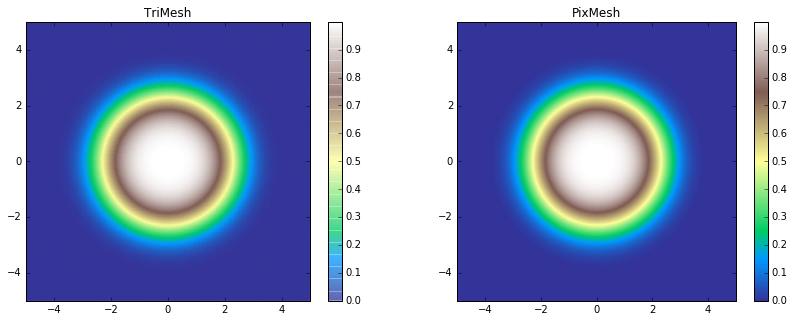

In [4]:
height = np.exp(-0.025*(points_x**2 + points_y**2)**2).flatten()

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(14,5)

sm1 = tri_mesh.add_node_data_to_plot(ax1, height, alpha=0.5, cmap='terrain')
fig.colorbar(sm1, ax=ax1)
ax1.set_xlim([minX, maxX])
ax1.set_ylim([minY, maxY])
ax1.set_title('TriMesh')

sm2 = pix_mesh.add_node_data_to_plot(ax2, height, cmap='terrain')
fig.colorbar(sm2, ax=ax2)
ax2.set_title('PixMesh')

plt.show()

## Surface processes

`HeightMesh` and `SurfaceProcessMesh` objects are built upon the `TriMesh` or `PixMesh` classes.
Below is an erosion-deposition example.

Setup the model...

In [5]:
points_x = points_x.flatten()
points_y = points_y.flatten()
bmask = bmask.flatten()

points_z = np.exp(-0.025*(points_x**2 + points_y**2)**2) + 0.0001 * np.random.rand(points_x.size)
points_z -= points_z[~bmask].mean()     # Boundary is at zero which we define as the base level

points_r = points_z**2 # Rainfall pattern

tri_mesh = badlands.SurfaceProcessMesh("TriMesh")
# tri_mesh.verbose = True
tri_mesh.build_mesh(points_x, points_y, bmask)
tri_mesh.update_height(points_z)
tri_mesh.update_surface_processes(points_r, np.zeros_like(points_r))

pix_mesh = badlands.SurfaceProcessMesh("PixMesh")
# pix_mesh.verbose = True
pix_mesh.build_mesh(points_x, points_y, bmask)
pix_mesh.update_height(points_z)
pix_mesh.update_surface_processes(points_r, np.zeros_like(points_r))

VirtualDecomposition __init__fn
VirtualMesh __init__fn
Topo mesh init
VirtualSPMesh __init__ fn
Surface mesh init
VirtualDecomposition __init__fn
VirtualMesh __init__fn
Topo mesh init
VirtualSPMesh __init__ fn
Surface mesh init


Erosion-deposition for `TriMesh`...

depo min/max, mean 0.0 4345.19524695 0.0354709816077
depo min/max, mean 0.0 4360.61085376 0.035596823296
depo min/max, mean 0.0 4376.87461596 0.0357295887017


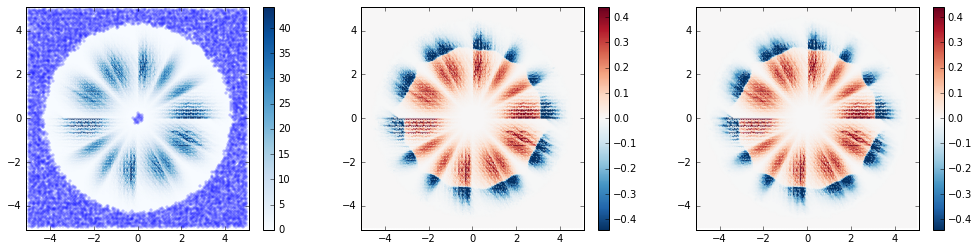

In [6]:
# def erosion_deposition(mesh):

# This is how to obtain the erosion rate / deposition rate

# tri_mesh.update_height(z5)
# tri_mesh.update_surface_processes()

# erosion_rate, deposition_rate, stream_power = tri_mesh.stream_power_erosion_deposition_rate(0.01, 0, 0, 0, 0)
# erosion_deposition_rate = erosion_rate - deposition_rate

erosion_rate, deposition_rate, stream_power = \
         tri_mesh.stream_power_erosion_deposition_rate2(efficiency=0.01, 
                                                    smooth_power=0, 
                                                    smooth_low_points=2, 
                                                    smooth_erosion_rate=0, 
                                                    smooth_deposition_rate=2, 
                                                    smooth_operator=tri_mesh.downhill_smoothing,
                                                    centre_weight_u=0.75, centre_weight=0.5)

    
    
erosion_deposition_rate = erosion_rate - deposition_rate

flat_spots = tri_mesh.identify_flat_spots()
smoothed_deposition_rate = deposition_rate.copy()
smoothed_deposition_rate[np.invert(flat_spots)] = 0.0

#for i in range(0, 5):
smoothed_deposition_rate = tri_mesh.local_area_smoothing(smoothed_deposition_rate, its=2, centre_weight=0.5)
    # smoothed_deposition_rate = tri_mesh.downhill_smoothing(smoothed_deposition_rate, its=1, centre_weight=0.5)

deposition_rate[flat_spots] = smoothed_deposition_rate[flat_spots]
     
erosion_deposition_rate2 = erosion_rate - deposition_rate


print "depo min/max, mean", deposition_rate.min(), deposition_rate.sum(), deposition_rate.mean()

deposition_rate2 = tri_mesh.streamwise_smoothing(deposition_rate, 5)

print "depo min/max, mean", deposition_rate2.min(), deposition_rate2.sum(), deposition_rate2.mean()

deposition_rate3 = tri_mesh.local_area_smoothing(deposition_rate, 5, centre_weight=0.5)
print "depo min/max, mean", deposition_rate3.min(), deposition_rate3.sum(), deposition_rate3.mean()

not_so_low_points = []
for node in tri_mesh.low_points:
    if tri_mesh.height[node] > 0.005 * tri_mesh.height.max():
        not_so_low_points.append(node)

fig, (plot1, plot2, plot3) = plt.subplots(1,3)
fig.set_size_inches(17,4)

plot1.set_xlim(-5.1, 5.1)
plot1.set_ylim(-5.1, 5.1)
plot2.set_xlim(-5.1, 5.1)
plot2.set_ylim(-5.1, 5.1)
plot3.set_xlim(-5.1, 5.1)
plot3.set_ylim(-5.1, 5.1)


maxED  =    erosion_deposition_rate[bmask].max() / 2.0 
maxPWR =    stream_power[bmask].max() / 2.0
#maxCUM =    cumulative_rain[bmask].max() / 2.0

sm1 = tri_mesh.add_node_data_to_plot(plot1, stream_power, vmin=0.0, vmax=maxPWR, cmap=cm.Blues,  shading="gouraud")
#plot1.tricontour(tri_mesh.x, tri_mesh.y, tri_mesh.tri.simplices.copy(), tri_mesh.height, (0.001, 0.01, 0.1, 0.99))
#sm1b = tri_mesh.add_node_data_to_plot(plot1, tri_mesh.rainfall_pattern, cmap=cm.BrBG, shading="gouraud", alpha=0.1)
plot1.scatter(tri_mesh.x[tri_mesh.low_points], tri_mesh.y[tri_mesh.low_points],10, marker="o", alpha=0.25, linewidth=0.0)


fig.colorbar(sm1, ax=plot1)

sm2 = tri_mesh.add_node_data_to_plot(plot2, erosion_deposition_rate, vmin=-maxED, vmax=maxED, cmap=cm.RdBu_r,  shading="gouraud") #, vmax=maxDR)
fig.colorbar(sm2, ax=plot2)

sm3 = tri_mesh.add_node_data_to_plot(plot3, erosion_deposition_rate2, vmin=-maxED, vmax=maxED, cmap=cm.RdBu_r,  shading="gouraud") #, vmax=maxDR)
fig.colorbar(sm3, ax=plot3)

# fig.savefig("erosion-deposition-power.png", dpi=300)
# plt.close()


Erosion-deposition for `PixMesh`...

depo min/max, mean 0.0 0.0614497753018 5.0163081879e-07
depo min/max, mean 0.0 0.0614059153346 5.01272778242e-07
depo min/max, mean 0.0 0.0614497753018 5.0163081879e-07


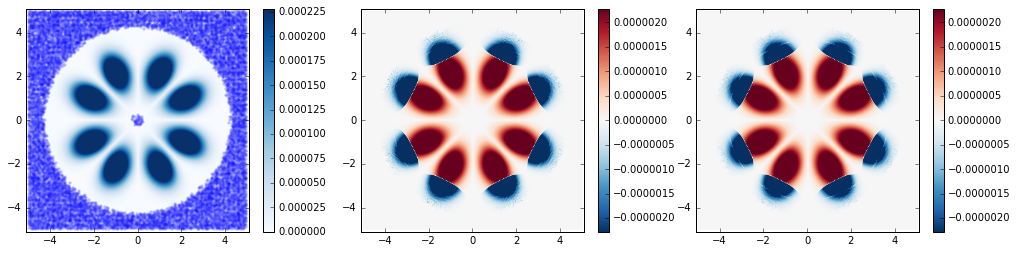

In [7]:
# def erosion_deposition(mesh):

# This is how to obtain the erosion rate / deposition rate

# pix_mesh.update_height(z5)
# pix_mesh.update_surface_processes()

# erosion_rate, deposition_rate, stream_power = pix_mesh.stream_power_erosion_deposition_rate(0.01, 0, 0, 0, 0)
# erosion_deposition_rate = erosion_rate - deposition_rate

erosion_rate, deposition_rate, stream_power = \
         pix_mesh.stream_power_erosion_deposition_rate2(efficiency=0.01, 
                                                    smooth_power=0, 
                                                    smooth_low_points=2, 
                                                    smooth_erosion_rate=0, 
                                                    smooth_deposition_rate=2, 
                                                    smooth_operator=pix_mesh.downhill_smoothing,
                                                    centre_weight_u=0.75, centre_weight=0.5)

    
    
erosion_deposition_rate = erosion_rate - deposition_rate

flat_spots = pix_mesh.identify_flat_spots()
smoothed_deposition_rate = deposition_rate.copy()
smoothed_deposition_rate[np.invert(flat_spots)] = 0.0

#for i in range(0, 5):
smoothed_deposition_rate = pix_mesh.local_area_smoothing(smoothed_deposition_rate, its=2, centre_weight=0.5)
    # smoothed_deposition_rate = pix_mesh.downhill_smoothing(smoothed_deposition_rate, its=1, centre_weight=0.5)

deposition_rate[flat_spots] = smoothed_deposition_rate[flat_spots]
     
erosion_deposition_rate2 = erosion_rate - deposition_rate


print "depo min/max, mean", deposition_rate.min(), deposition_rate.sum(), deposition_rate.mean()

deposition_rate2 = pix_mesh.streamwise_smoothing(deposition_rate, 5)

print "depo min/max, mean", deposition_rate2.min(), deposition_rate2.sum(), deposition_rate2.mean()

deposition_rate3 = pix_mesh.local_area_smoothing(deposition_rate, 5, centre_weight=0.5)
print "depo min/max, mean", deposition_rate3.min(), deposition_rate3.sum(), deposition_rate3.mean()

not_so_low_points = []
for node in pix_mesh.low_points:
    if pix_mesh.height[node] > 0.005 * pix_mesh.height.max():
        not_so_low_points.append(node)

fig, (plot1, plot2, plot3) = plt.subplots(1,3)
fig.set_size_inches(17,4)

plot1.set_xlim(-5.1, 5.1)
plot1.set_ylim(-5.1, 5.1)
plot2.set_xlim(-5.1, 5.1)
plot2.set_ylim(-5.1, 5.1)
plot3.set_xlim(-5.1, 5.1)
plot3.set_ylim(-5.1, 5.1)


maxED  =    erosion_deposition_rate[bmask].max() / 2.0 
maxPWR =    stream_power[bmask].max() / 2.0
#maxCUM =    cumulative_rain[bmask].max() / 2.0

sm1 = pix_mesh.add_node_data_to_plot(plot1, stream_power, vmin=0.0, vmax=maxPWR, cmap=cm.Blues)
#plot1.tricontour(pix_mesh.x, pix_mesh.y, pix_mesh.tri.simplices.copy(), pix_mesh.height, (0.001, 0.01, 0.1, 0.99))
#sm1b = pix_mesh.add_node_data_to_plot(plot1, pix_mesh.rainfall_pattern, cmap=cm.BrBG, shading="gouraud", alpha=0.1)
plot1.scatter(pix_mesh.x[pix_mesh.low_points], pix_mesh.y[pix_mesh.low_points],10, marker="o", alpha=0.25, linewidth=0.0)


fig.colorbar(sm1, ax=plot1)

sm2 = pix_mesh.add_node_data_to_plot(plot2, erosion_deposition_rate, vmin=-maxED, vmax=maxED, cmap=cm.RdBu_r) #, vmax=maxDR)
fig.colorbar(sm2, ax=plot2)

sm3 = pix_mesh.add_node_data_to_plot(plot3, erosion_deposition_rate2, vmin=-maxED, vmax=maxED, cmap=cm.RdBu_r) #, vmax=maxDR)
fig.colorbar(sm3, ax=plot3)

# fig.savefig("erosion-deposition-power.png", dpi=300)
#plt.close()


### Timesteps

Watch how the drainage pattern evolves.
We are careful to clear the axis after every save to avoid memory issues.

In [8]:
## Make a series of plots to show the flow of information on this mesh

# vector = tri_mesh.area.copy()

vector = np.ones(tri_mesh.npoints)

DX0 = vector.copy()
DX1 = vector.copy()

fig = plt.figure(1, figsize=(5,5))
lim = 5.0

step=0
while DX1.any() and step < 150: 
    
    if step%5==0 or step < 10:
        plot1 = fig.add_subplot(111, xlim=[-lim,lim], ylim=[-lim,lim])
        plot1.axes.set_aspect("equal")
        
        sm1 = tri_mesh.add_node_data_to_plot(plot1, DX1, vmin=0.0, vmax=1.0, cmap=cm.YlOrRd)
        fig.savefig("TriMeshPropagation.{:03d}.png".format(step), dpi=300)
        plt.cla()
        
        print "step", step
    
    step += 1
    
    DX1 = tri_mesh.downhillMat.dot(DX1)
    DX0 += DX1    

plt.clf()

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 15
step 20
step 25
step 30
step 35
step 40
step 45
step 50
step 55
step 60
step 65
step 70
step 75
step 80
step 85
step 90
step 95
step 100
step 105
step 110
step 115
step 120
step 125
step 130
step 135
step 140
step 145


In [9]:
## Make a series of plots to show the flow of information on this mesh

# vector = pix_mesh.area.copy()

vector = np.ones(pix_mesh.npoints)

DX0 = vector.copy()
DX1 = vector.copy()

fig = plt.figure(1, figsize=(5,5))
lim = 5.0

step=0
while DX1.any() and step < 150: 
    
    if step%5==0 or step < 10:
        plot1 = fig.add_subplot(111, xlim=[-lim,lim], ylim=[-lim,lim])
        plot1.axes.set_aspect("equal")
        
        sm1 = pix_mesh.add_node_data_to_plot(plot1, DX1, vmin=0.0, vmax=1.0, cmap=cm.YlOrRd)
        fig.savefig("PixMeshPropagation.{:03d}.png".format(step), dpi=300)
        plt.cla()
        
        print "step", step
    
    step += 1
    
    DX1 = pix_mesh.downhillMat.dot(DX1)
    DX0 += DX1    

plt.clf()

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 15
step 20
step 25
step 30
step 35
step 40
step 45
step 50
step 55
step 60
step 65
step 70
step 75
step 80
step 85
step 90
step 95
step 100
step 105
step 110
step 115
step 120
step 125
step 130
step 135
step 140
step 145
